# Privacy Aware Diversity Aware Generation  


generate image and check how consistent it is 

In [1]:
%run ../basesetup.ipynb 
transform = T.Compose([T.ToTensor(), T.Resize(512)])  # Replace with your transforms if needed


In [2]:
# load basic functions such as generative model initializer, classification model, privacy mdoel
privnet = get_privacy_model()
privnet = privnet.to("cuda")

clf_model_path = "/vol/ideadata/ed52egek/pycharm/trichotomy/importantmodels/results_chexnet_real/saved_models_cxr8/m-05122024-131940.pth.tar"
clf_model = get_classification_model(clf_model_path)
clf_model = clf_model.to("cuda")

/vol/ideadata/ed52egek/miniconda/envs/trichotomy/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/vol/ideadata/ed52egek/miniconda/envs/trichotomy/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_2474730/2998257040.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https:

In [6]:
from collections import defaultdict
N = 1000
# Path to your txt file
file_path = "/vol/ideadata/ed52egek/pycharm/trichotomy/privacy/image_pairs/TRAIN_pairs_cxr8.txt"

# Dictionary to group image pairs by subject ID
subject_pairs = defaultdict(list)

# Read the file and process it
image_list = []
with open(file_path, 'r') as f:
    last_subject_id = 0
    for line in f:
        img1, img2, label = line.strip().split()
        subject_id = img1.split('_')[0].split('/')[-1]  # Extract subject ID
        if subject_id != last_subject_id:
            image_list.append(img1)
            image_list.append(img2)
            last_subject_id = subject_id
        #subject_pairs[subject_id].append((img1, img2))

image_list_pairs = [{"full_path":x, "model_name": "", "class_name":""} for x in image_list[:N]]
print(image_list_pairs[:5])
image_list_pairs = ImageDatasetReal(root_dir="/vol/ideadata/ed52egek/data/chestxray14", real_files=image_list_pairs, transform=transform)


[{'full_path': 'images/00000001_000.png', 'model_name': '', 'class_name': ''}, {'full_path': 'images/00000001_001.png', 'model_name': '', 'class_name': ''}, {'full_path': 'images/00000005_000.png', 'model_name': '', 'class_name': ''}, {'full_path': 'images/00000005_001.png', 'model_name': '', 'class_name': ''}, {'full_path': 'images/00000008_000.png', 'model_name': '', 'class_name': ''}]


In [3]:
from collections import defaultdict
N = 1000
# Path to your txt file
file_path = "/vol/ideadata/ed52egek/pycharm/trichotomy/privacy/image_pairs/TRAIN_pairs_cxr8.txt"

# Dictionary to group image pairs by subject ID
subject_pairs = defaultdict(list)

# Read the file and process it
image_list = []
with open(file_path, 'r') as f:
    last_subject_id = 0
    for line in f:
        img1, img2, label = line.strip().split()
        subject_id = img1.split('_')[0].split('/')[-1]  # Extract subject ID
        if subject_id != last_subject_id:
            image_list.append(img1)
            #image_list.append(img2)
            last_subject_id = subject_id
        #subject_pairs[subject_id].append((img1, img2))


image_list_no_pairs = [{"full_path":x, "model_name": "", "class_name":""} for x in image_list[:N]]
print(image_list_no_pairs[:5])
image_list_no_pairs = ImageDatasetReal(root_dir="/vol/ideadata/ed52egek/data/chestxray14", real_files=image_list_no_pairs, transform=transform)

[{'full_path': 'images/00000001_000.png', 'model_name': '', 'class_name': ''}, {'full_path': 'images/00000005_000.png', 'model_name': '', 'class_name': ''}, {'full_path': 'images/00000008_000.png', 'model_name': '', 'class_name': ''}, {'full_path': 'images/00000013_023.png', 'model_name': '', 'class_name': ''}, {'full_path': 'images/00000017_000.png', 'model_name': '', 'class_name': ''}]


In [4]:
image_list_snth = SnthImageDataset("/vol/ideadata/ed52egek/pycharm/trichotomy/notebooks/02_eval_synthetic/generated_images_duplicates_new", transform=transform)
print(image_list_snth.image_list[:5])
image_list_snth



[{'model_name': 'DiADM', 'class_name': 'No_Finding', 'real_image_name': '00000002_000.png', 'full_path': '/vol/ideadata/ed52egek/pycharm/trichotomy/notebooks/02_eval_synthetic/generated_images_duplicates_new/DiADM/No_Finding/images/00000002_000_seed_0.png'}, {'model_name': 'DiADM', 'class_name': 'No_Finding', 'real_image_name': '00000002_000.png', 'full_path': '/vol/ideadata/ed52egek/pycharm/trichotomy/notebooks/02_eval_synthetic/generated_images_duplicates_new/DiADM/No_Finding/images/00000002_000_seed_1.png'}, {'model_name': 'DiADM', 'class_name': 'No_Finding', 'real_image_name': '00000005_000.png', 'full_path': '/vol/ideadata/ed52egek/pycharm/trichotomy/notebooks/02_eval_synthetic/generated_images_duplicates_new/DiADM/No_Finding/images/00000005_000_seed_2.png'}, {'model_name': 'DiADM', 'class_name': 'No_Finding', 'real_image_name': '00000005_000.png', 'full_path': '/vol/ideadata/ed52egek/pycharm/trichotomy/notebooks/02_eval_synthetic/generated_images_duplicates_new/DiADM/No_Finding/i

In [7]:
from torch.utils.data import ConcatDataset, DataLoader
def run_inference(dataset): 
    # Create a DataLoader
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

    results = {
        "f_p": [],
        "f_clf": [],
        "pred": [],
        "is_real": [],
        "model_name": [],
        "class_name": [],
        "full_path": [],
        "real_image_name": [],
    }

    # Iterate through the DataLoader
    for data in tqdm.tqdm(dataloader):
        # Process the data
        f_p = privnet.lazy_forward_once(data["image"])
        pred, f_clf = clf_model.lazy_foward(data["image"])

        for k, v in results.items():
            if k not in ["f_p", "f_clf", "pred", "is_real"]:
                results[k].extend(data[k])
            if k == "is_real": 
                results[k].extend([l.item() for l in data[k]])

        results["f_p"].extend(list(f_p.cpu()))
        results["f_clf"].extend(list(f_clf.cpu()))
        results["pred"].extend(list(pred.cpu()))
    return results

results_real_pair = run_inference(image_list_pairs)
results_real_no_pair = run_inference(image_list_no_pairs)
results_snth = run_inference(image_list_snth)

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:07<00:00,  4.31it/s]


In [8]:
from torch.nn.functional import binary_cross_entropy
import numpy as np

real_score_paired = []
real_score_unpaired = []
snth_score_paired = []
for i in np.arange(start=0, stop=N, step=2): 
    real_score_paired.append(binary_cross_entropy(results_real_pair["pred"][i], results_real_pair["pred"][i+1]).item())
    real_score_unpaired.append(binary_cross_entropy(results_real_no_pair["pred"][i], results_real_no_pair["pred"][i+1]).item())
    snth_score_paired.append(binary_cross_entropy(results_snth["pred"][i], results_snth["pred"][i+1]).item())



Mean Synthetic: 0.10586682317545637
Mean Real Paired: 0.165454083816614
Mean Real Not Paired: 0.2129152932353318


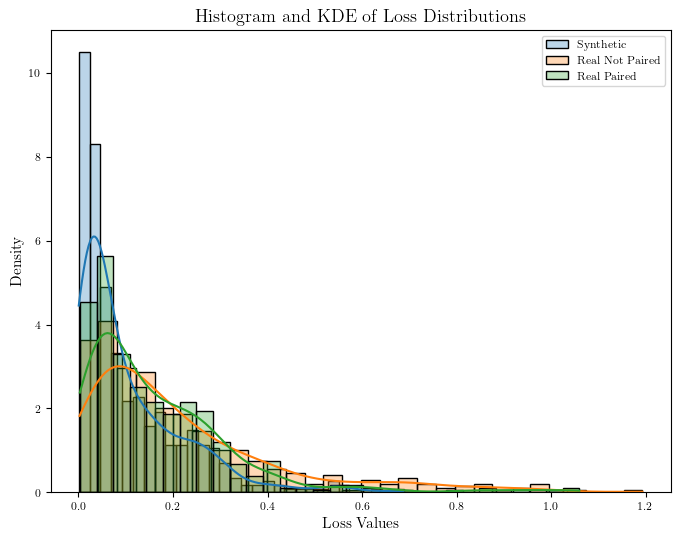

In [9]:
print(f"Mean Synthetic: {np.array(snth_score_paired).mean()}")
print(f"Mean Real Paired: {np.array(real_score_paired).mean()}")
print(f"Mean Real Not Paired: {np.array(real_score_unpaired).mean()}")

# Labels for the legend
labels = ["Synthetic", "Real Not Paired", "Real Paired"]

# Plot histogram with KDE
plt.figure(figsize=(8, 6))
sns.histplot(snth_score_paired, kde=True, label=labels[0], stat="density", bins=30, alpha=0.3)
sns.histplot(real_score_unpaired, kde=True, label=labels[1], stat="density", bins=30, alpha=0.3)
sns.histplot(real_score_paired, kde=True, label=labels[2], stat="density", bins=30, alpha=0.3)

# Labels and legend
plt.xlabel("Loss Values")
plt.ylabel("Density")
plt.title("Histogram and KDE of Loss Distributions")
plt.savefig("kde_hist_different_pairs_classifierprediction.pdf")
plt.legend()

# Show the plot
plt.show()

/tmp/ipykernel_2474730/3134873795.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  snth_score_paired = torch.tensor(snth_score_paired)
/tmp/ipykernel_2474730/3134873795.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_score_paired = torch.tensor(real_score_paired)
/tmp/ipykernel_2474730/3134873795.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_score_unpaired = torch.tensor(real_score_unpaired)
/tmp/ipykernel_2474730/3134873795.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing

Mean Synthetic: 0.1059
Mean Real Paired: 0.1655
Mean Real Not Paired: 0.2129


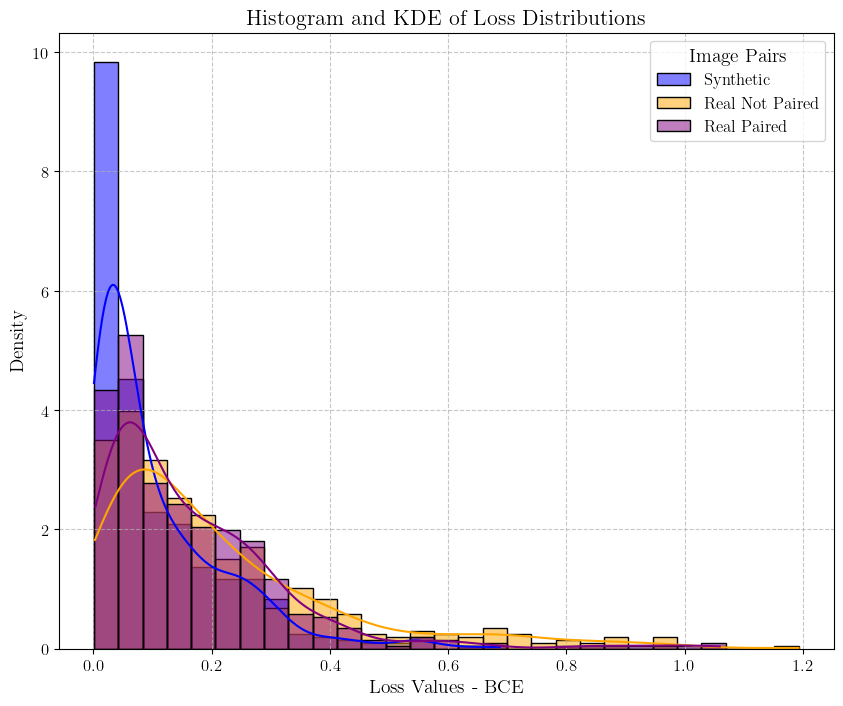

In [12]:
snth_score_paired = torch.tensor(snth_score_paired)
real_score_paired = torch.tensor(real_score_paired)
real_score_unpaired = torch.tensor(real_score_unpaired)
# Calculate and print mean values
print(f"Mean Synthetic: {np.array(snth_score_paired).mean():.4f}")
print(f"Mean Real Paired: {np.array(real_score_paired).mean():.4f}")
print(f"Mean Real Not Paired: {np.array(real_score_unpaired).mean():.4f}")

# Labels for the legend
labels = ["Synthetic", "Real Not Paired", "Real Paired"]

# Set up the figure
plt.figure(figsize=(10, 8))  # Increased size for better visibility


# Define bins explicitly based on the combined data range
bin_edges = np.linspace(
    min(snth_score_paired.min(), real_score_unpaired.min(), real_score_paired.min()), 
    max(snth_score_paired.max(), real_score_unpaired.max(), real_score_paired.max()), 
    30  # Number of bins
)

# Plot histograms with predefined bins
sns.histplot(
    snth_score_paired, kde=True, label=labels[0], stat="density",
    bins=bin_edges, alpha=0.5, color="blue", edgecolor="black"
)
sns.histplot(
    real_score_unpaired, kde=True, label=labels[1], stat="density",
    bins=bin_edges, alpha=0.5, color="orange", edgecolor="black"
)
sns.histplot(
    real_score_paired, kde=True, label=labels[2], stat="density",
    bins=bin_edges, alpha=0.5, color="purple", edgecolor="black"
)

# Add gridlines
plt.grid(visible=True, linestyle="--", alpha=0.7)

# Labels and title with larger font size
plt.xlabel("Loss Values - BCE", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("Histogram and KDE of Loss Distributions", fontsize=16, fontweight="bold")

# Adjust ticks for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust the legend
plt.legend(title="Image Pairs", fontsize=12, title_fontsize=14, loc="upper right", frameon=True)

# Add a log scale option for the x-axis (optional, uncomment if needed)
# plt.xscale('log')

# Save the plot
plt.savefig("kde_hist_different_pairs_classifierprediction.pdf", bbox_inches="tight", dpi=300)

# Show the plot
plt.show()